# 분류 모델 구축: 맛있는 아시아 및 인도 요리


## 요리 분류기 1

이번 강의에서는 *재료 그룹을 기반으로 특정 국가의 요리를 예측*하는 다양한 분류기를 탐구합니다. 이를 통해 분류 작업에 알고리즘을 활용하는 방법에 대해 더 깊이 배워볼 것입니다.

### [**강의 전 퀴즈**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **준비**

이번 강의는 [이전 강의](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb)를 기반으로 진행됩니다. 이전 강의에서는:

-   아시아와 인도의 다양한 요리 데이터를 사용하여 분류에 대해 간단히 소개했습니다. 😋

-   데이터를 준비하고 정리하기 위해 [dplyr 동사](https://dplyr.tidyverse.org/)를 탐구했습니다.

-   ggplot2를 사용하여 아름다운 시각화를 만들었습니다.

-   [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html)를 사용하여 불균형 데이터를 전처리하는 방법을 시연했습니다.

-   `prep`과 `bake`를 사용하여 레시피가 의도한 대로 작동하는지 확인하는 방법을 보여주었습니다.

#### **사전 요구 사항**

이번 강의에서는 데이터를 정리하고 준비하며 시각화하기 위해 다음 패키지가 필요합니다:

-   `tidyverse`: [tidyverse](https://www.tidyverse.org/)는 데이터 과학을 더 빠르고, 쉽고, 재미있게 만들어주는 [R 패키지 모음](https://www.tidyverse.org/packages)입니다.

-   `tidymodels`: [tidymodels](https://www.tidymodels.org/) 프레임워크는 모델링과 머신러닝을 위한 [패키지 모음](https://www.tidymodels.org/packages/)입니다.

-   `themis`: [themis 패키지](https://themis.tidymodels.org/)는 불균형 데이터를 처리하기 위한 추가 레시피 단계를 제공합니다.

-   `nnet`: [nnet 패키지](https://cran.r-project.org/web/packages/nnet/nnet.pdf)는 단일 은닉층을 가진 피드포워드 신경망과 다항 로지스틱 회귀 모델을 추정하는 기능을 제공합니다.

다음과 같이 패키지를 설치할 수 있습니다:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

또는 아래 스크립트는 이 모듈을 완료하는 데 필요한 패키지가 설치되어 있는지 확인하고, 누락된 경우 이를 설치합니다.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



이제 바로 시작해봅시다!

## 1. 데이터를 학습용 세트와 테스트 세트로 나누기

이전 강의에서 다뤘던 몇 가지 단계를 선택하여 시작해봅시다.

### 서로 다른 요리 간에 혼란을 일으키는 가장 흔한 재료들을 제거하기 위해 `dplyr::select()`를 사용하세요.

모두가 쌀, 마늘, 생강을 좋아하죠!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,⋯,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0


cuisine,n
<fct>,<int>
korean,799
indian,598
chinese,442
japanese,320
thai,289


이제 데이터를 70%는 학습용으로, 30%는 테스트용으로 나누어 봅시다. 또한 데이터를 나눌 때 `계층화` 기법을 적용하여 `각 요리의 비율`이 학습 및 검증 데이터셋에서 유지되도록 할 것입니다.

[rsample](https://rsample.tidymodels.org/)은 Tidymodels의 패키지로, 효율적인 데이터 분할 및 재샘플링을 위한 인프라를 제공합니다:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,⋯,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


cuisine,n
<fct>,<int>
korean,559
indian,418
chinese,309
japanese,224
thai,202


## 2. 불균형 데이터 처리하기

원본 데이터 세트와 학습 데이터 세트를 살펴보면, 요리 종류의 수가 상당히 불균형하게 분포되어 있다는 것을 알 수 있습니다. 한국 요리는 태국 요리의 *거의* 3배에 달합니다. 불균형 데이터는 모델 성능에 부정적인 영향을 미치는 경우가 많습니다. 많은 모델은 관측치의 수가 동일할 때 가장 잘 작동하며, 따라서 불균형 데이터에서는 어려움을 겪는 경향이 있습니다.

불균형 데이터 세트를 처리하는 주요 방법은 두 가지가 있습니다:

-   소수 클래스의 관측치를 추가하는 방법: `오버샘플링` 예를 들어, SMOTE 알고리즘을 사용하여 소수 클래스의 새로운 예제를 이들의 가까운 이웃을 기반으로 합성하여 생성하는 방식입니다.

-   다수 클래스의 관측치를 제거하는 방법: `언더샘플링`

이전 강의에서 우리는 `recipe`를 사용하여 불균형 데이터 세트를 처리하는 방법을 시연했습니다. `recipe`는 데이터 분석을 준비하기 위해 데이터 세트에 어떤 단계를 적용해야 하는지를 설명하는 청사진으로 생각할 수 있습니다. 우리의 경우, `training set`에서 요리 수의 분포를 균등하게 맞추고자 합니다. 바로 시작해 봅시다.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

이 레시피가 예상대로 작동하는지 확인하려면 (prep과 bake를 사용하여) 직접 확인해보세요. 모든 요리 레이블에 `559`개의 관측값이 있는지 확인하면 됩니다.

이 레시피를 모델링을 위한 전처리기로 사용할 예정이므로, `workflow()`를 사용하면 prep과 bake를 모두 자동으로 처리해주기 때문에 레시피를 수동으로 추정할 필요가 없습니다.

이제 모델을 훈련할 준비가 되었습니다 👩‍💻👨‍💻!

## 3. 분류기 선택하기

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>@allison_horst의 작품</figcaption>


이제 어떤 알고리즘을 사용할지 결정해야 합니다 🤔.

Tidymodels의 [`parsnip 패키지`](https://parsnip.tidymodels.org/index.html)는 다양한 엔진(패키지)에서 모델을 일관되게 사용할 수 있는 인터페이스를 제공합니다. [모델 유형 및 엔진](https://www.tidymodels.org/find/parsnip/#models)과 해당 [모델 인수](https://www.tidymodels.org/find/parsnip/#model-args)를 탐색하려면 parsnip 문서를 참조하세요. 처음에는 그 다양성이 꽤 혼란스러울 수 있습니다. 예를 들어, 다음 방법들은 모두 분류 기법을 포함합니다:

-   C5.0 규칙 기반 분류 모델

-   유연한 판별 모델

-   선형 판별 모델

-   정규화된 판별 모델

-   로지스틱 회귀 모델

-   다항 회귀 모델

-   나이브 베이즈 모델

-   서포트 벡터 머신

-   최근접 이웃

-   의사결정 트리

-   앙상블 방법

-   신경망

목록은 계속됩니다!

### **어떤 분류기를 선택할까?**

그렇다면 어떤 분류기를 선택해야 할까요? 종종 여러 가지를 실행해보고 좋은 결과를 찾는 것이 테스트 방법이 될 수 있습니다.

> AutoML은 클라우드에서 이러한 비교를 실행하여 데이터에 가장 적합한 알고리즘을 선택할 수 있도록 함으로써 이 문제를 깔끔하게 해결합니다. [여기](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)에서 시도해보세요.

또한 분류기 선택은 문제에 따라 달라집니다. 예를 들어, 결과가 `두 개 이상의 클래스`로 분류될 수 있는 경우, 우리 사례처럼 `이진 분류`가 아닌 `다중 클래스 분류 알고리즘`을 사용해야 합니다.

### **더 나은 접근법**

그러나 무작위로 추측하는 것보다 더 나은 방법은 이 다운로드 가능한 [ML 치트 시트](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott)의 아이디어를 따르는 것입니다. 여기에서 우리는 다중 클래스 문제에 대해 몇 가지 선택지가 있다는 것을 발견합니다:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Microsoft의 알고리즘 치트 시트의 일부로, 다중 클래스 분류 옵션을 자세히 설명</figcaption>


### **이유**

제약 조건을 고려하여 다양한 접근 방식을 논리적으로 검토해 봅시다:

-   **딥 뉴럴 네트워크는 너무 무겁다**. 데이터셋이 깨끗하지만 최소한의 데이터만 있고, 노트북에서 로컬로 학습을 실행하는 상황에서는 딥 뉴럴 네트워크는 이 작업에 비해 지나치게 무겁습니다.

-   **이진 분류기는 사용하지 않는다**. 이진 분류기를 사용하지 않으므로 one-vs-all 방식은 제외됩니다.

-   **결정 트리나 로지스틱 회귀는 가능하다**. 결정 트리는 가능성이 있으며, 다중 클래스 데이터를 위한 다항 회귀/다중 클래스 로지스틱 회귀도 가능성이 있습니다.

-   **다중 클래스 부스팅 결정 트리는 다른 문제를 해결한다**. 다중 클래스 부스팅 결정 트리는 비모수적 작업(예: 순위 생성 작업)에 가장 적합하므로, 우리에게는 적합하지 않습니다.

또한, 일반적으로 앙상블 방법과 같은 복잡한 머신러닝 모델을 시도하기 전에, 가능한 가장 간단한 모델을 구축하여 데이터의 특성을 파악하는 것이 좋습니다. 따라서 이번 학습에서는 `다항 회귀` 모델로 시작하겠습니다.

> 로지스틱 회귀는 결과 변수가 범주형(또는 명목형)일 때 사용하는 기법입니다. 이진 로지스틱 회귀에서는 결과 변수가 두 개이고, 다항 로지스틱 회귀에서는 결과 변수가 두 개 이상입니다. 추가 학습을 원한다면 [고급 회귀 방법](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html)을 참조하세요.

## 4. 다항 로지스틱 회귀 모델 학습 및 평가

Tidymodels에서 `parsnip::multinom_reg()`는 선형 예측 변수를 사용하여 다항 분포를 통해 다중 클래스 데이터를 예측하는 모델을 정의합니다. 이 모델을 학습시키기 위해 사용할 수 있는 다양한 방법/엔진은 `?multinom_reg()`를 참조하세요.

이번 예제에서는 기본 [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) 엔진을 사용하여 다항 회귀 모델을 학습시킬 것입니다.

> `penalty` 값을 다소 임의로 선택했습니다. 이 값을 선택하는 더 나은 방법은 `resampling`과 모델 `튜닝`을 사용하는 것으로, 이는 이후에 다룰 예정입니다.
>
> 모델 하이퍼파라미터를 튜닝하는 방법에 대해 더 알고 싶다면 [Tidymodels: 시작하기](https://www.tidymodels.org/start/tuning/)를 참조하세요.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


멋져요 🥳! 이제 레시피와 모델 사양을 준비했으니, 이 둘을 하나의 객체로 묶는 방법을 찾아야 합니다. 이 객체는 먼저 데이터를 전처리하고, 전처리된 데이터에 모델을 학습시키며, 추가적으로 후처리 작업도 가능하게 해줍니다. Tidymodels에서는 이 편리한 객체를 [`workflow`](https://workflows.tidymodels.org/)라고 부르며, 여러분의 모델링 구성 요소를 간편하게 담아줍니다! 이는 *Python*에서 *파이프라인(pipelines)*이라고 부르는 것과 유사합니다.

그럼 이제 모든 것을 workflow로 묶어봅시다!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


워크플로 👌👌! **`workflow()`**는 모델과 거의 동일한 방식으로 적합할 수 있습니다. 자, 이제 모델을 훈련할 시간입니다!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

모델이 학습 중에 학습한 계수를 출력합니다.

### 학습된 모델 평가하기

이제 테스트 세트를 사용하여 모델이 어떻게 성능을 발휘했는지 평가할 시간입니다 📏! 먼저 테스트 세트에 대한 예측을 만들어 봅시다.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine,.pred_class
<fct>,<fct>
indian,thai
indian,indian
indian,indian
indian,indian
indian,indian


훌륭해요! Tidymodels에서는 [yardstick](https://yardstick.tidymodels.org/)을 사용하여 모델 성능을 평가할 수 있습니다. yardstick은 성능 지표를 사용하여 모델의 효과를 측정하는 데 사용되는 패키지입니다. 로지스틱 회귀 수업에서 했던 것처럼, 혼동 행렬을 계산하는 것부터 시작해 봅시다.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

여러 클래스를 다룰 때, 일반적으로 이를 열 지도처럼 시각화하는 것이 더 직관적입니다.


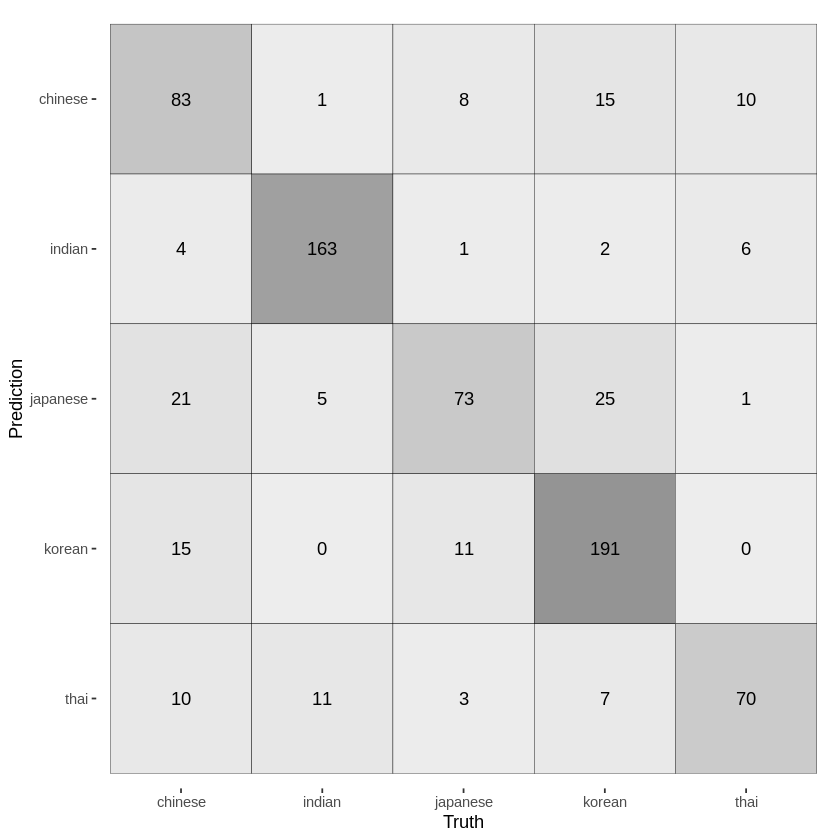

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

혼동 행렬 플롯에서 더 어두운 사각형은 많은 사례 수를 나타내며, 예측 레이블과 실제 레이블이 동일한 경우를 나타내는 어두운 사각형의 대각선 라인을 확인할 수 있을 것입니다.

이제 혼동 행렬에 대한 요약 통계를 계산해 보겠습니다.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7880435
kap,multiclass,0.7276583
sens,macro,0.7780927
spec,macro,0.9477598
ppv,macro,0.7585583
npv,macro,0.9460080
mcc,multiclass,0.7292724
j_index,macro,0.7258524
bal_accuracy,macro,0.8629262


만약 정확도, 민감도, 양성 예측도(ppv)와 같은 몇 가지 지표에 초점을 맞춘다면, 시작치고는 나쁘지 않은 결과네요 🥳!

## 4. 더 깊이 파고들기

한 가지 미묘한 질문을 던져봅시다: 특정 유형의 요리를 예측 결과로 선택하는 기준은 무엇일까요?

사실, 로지스틱 회귀와 같은 통계적 머신러닝 알고리즘은 `확률`에 기반을 둡니다. 따라서 분류기가 실제로 예측하는 것은 가능한 결과 집합에 대한 확률 분포입니다. 이 중 가장 높은 확률을 가진 클래스가 주어진 관찰값에 대해 가장 가능성 높은 결과로 선택됩니다.

이제 하드 클래스 예측과 확률을 모두 만들어보며 이를 실제로 확인해봅시다.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine,.pred_class,.pred_chinese,.pred_indian,.pred_japanese,.pred_korean,.pred_thai
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
indian,thai,1.551259e-03,0.4587877,5.988039e-04,2.428503e-04,5.388194e-01
indian,indian,2.637133e-05,0.9999488,6.648651e-07,2.259993e-05,1.577948e-06
indian,indian,1.049433e-03,0.9909982,1.060937e-03,1.644947e-05,6.874989e-03
indian,indian,6.237482e-02,0.4763035,9.136702e-02,3.660913e-01,3.863391e-03
indian,indian,1.431745e-02,0.9418551,2.945239e-02,8.721782e-03,5.653283e-03


훨씬 더 좋네요!

✅ 첫 번째 관찰이 태국 요리라고 모델이 확신하는 이유를 설명할 수 있나요?

## **🚀도전 과제**

이번 강의에서는 정리된 데이터를 사용하여 재료 목록을 기반으로 국가별 요리를 예측할 수 있는 머신러닝 모델을 구축했습니다. Tidymodels가 데이터를 분류하기 위해 제공하는 [다양한 옵션](https://www.tidymodels.org/find/parsnip/#models)과 다항 회귀를 적용하는 [다른 방법들](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models)을 읽어보는 시간을 가져보세요.

#### 감사의 말씀:

[`Allison Horst`](https://twitter.com/allison_horst/)에게 R을 더 친근하고 매력적으로 만들어주는 멋진 삽화를 제작해 주셔서 감사합니다. 그녀의 [갤러리](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM)에서 더 많은 삽화를 확인할 수 있습니다.

[Cassie Breviu](https://www.twitter.com/cassieview)와 [Jen Looper](https://www.twitter.com/jenlooper)에게 이 모듈의 원래 Python 버전을 만들어 주셔서 ♥️ 감사합니다.

<br>
음식 관련 농담을 던지고 싶었지만, 음식 말장난은 도넛(도저히) 이해가 안 되네요 😅.

<br>

즐거운 학습 되세요,

[Eric](https://twitter.com/ericntay), Gold Microsoft Learn Student Ambassador.



---

**면책 조항**:  
이 문서는 AI 번역 서비스 [Co-op Translator](https://github.com/Azure/co-op-translator)를 사용하여 번역되었습니다. 정확성을 위해 최선을 다하고 있으나, 자동 번역에는 오류나 부정확성이 포함될 수 있습니다. 원본 문서(원어로 작성된 문서)를 권위 있는 자료로 간주해야 합니다. 중요한 정보의 경우, 전문적인 인간 번역을 권장합니다. 이 번역 사용으로 인해 발생하는 오해나 잘못된 해석에 대해 당사는 책임을 지지 않습니다.  
